In [1]:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install -U renderlab
    !pip install -U colabgymrender
    !pip install -U moviepy==0.2.3.5
    !pip install imageio==2.4.1
    !pip install --upgrade AutoROM
    !AutoROM --accept-license
    !pip install gymnasium
    !pip install gym[classic_control] > /dev/null 2>&1
    !pip install stable_baselines3

import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from copy import deepcopy

from torch.utils.data import DataLoader
from torch import nn
import torch

from __future__ import annotations

from collections import defaultdict

import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm, trange

seed = 4756
data_seed = 700

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3114 sha256=abb52d080f28c1721fda72b5950e6b52a0dc6a08ad8b36885ca33db179fef87a
  Stored in directory: /root/.cache/pip/wheels/13/62/63/7b3acfb684dd3d665d7fc1d213427b136205a222389767e295
Successfully built colabgymrender
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for moviepy: filename=moviepy-0.2.3.5-py3-none-any.whl size=130191 sha256=b96043d2769635624a130881772a407fab7797995e16073bc71a2d82f4aaeb78
  Stored in directory: /root/.cache/pip/wheels/7c/a0/a9/112e9a44d5b0e5d07d434bd0b8b1bfc8efdf8e305c3332febb
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 1.0.3
    Uninstalling moviepy-1.0.3:
      Successfully uninstalled moviepy-1.0.3
     

In [27]:
original_env = gym.make("Blackjack-v1", sab=True)

In [3]:
def visualize(env_name="Blackjack-v1", algorithm=None, video_name="test", env_args={}):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            env_name: Name of the gym environment to roll out `algorithm` in, it will be instantiated using gym.make or make_vec_env
            algorithm (PPOActor): Actor whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    if USING_COLAB:
        from renderlab import RenderFrame

        directory = './video'
        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        env = RenderFrame(env, directory)
        obs, info = env.reset()

        for i in range(200):
            action = get_action(obs)
            obs, reward, done, truncate, info = env.step(action)

            if done:
                break

        env.play()
    else:
        import cv2

        video = cv2.VideoWriter(f"{video_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (600,400))

        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        obs, info = env.reset()

        for i in range(500):
            action = get_action(obs)
            res = env.step(action)
            obs, reward, done, truncate, info = res

            if done:
                break

            im = env.render()
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

In [4]:
visualize()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1269760/45929032 bytes (2.8%)3104768/45929032 bytes (6.8%)5726208/45929032 bytes (12.5%)6660096/45929032 bytes (14.5%)8683520/45929032 bytes (18.9%)10084352/45929032 bytes (22.0%)12722176/45929032 bytes (27.7%)14147584/45929032 bytes (30.8%)16318464/45929032 bytes (35.5%)18481152/45929032 bytes (40.2%)20766720/45929032 bytes (45.2%)23085056/45929032 bytes (50.3%)25567

 75%|███████▌  | 3/4 [00:00<00:00, 68.76it/s]


In [5]:
# Setting the seed to ensure reproducability
def reseed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

reseed(seed)

Average Reward when doing random action

In [43]:
from IPython import display as ipythondisplay


NUM_TRAJS = 100_000
visualize = False # set to false in order to disable rendering code
if visualize:
    plt.axis('off')
total_random_reward = 0
i = 0

for j in tqdm(range(NUM_TRAJS)):
  # print(f"Working on trajectory {j}")
  done = False
  obs = original_env.reset()
  while not done:
      i += 1
      if i%5==0 and visualize:
          ipythondisplay.clear_output(wait=True)
          screen = original_env.render()
          plt.imshow(screen[0])
          ipythondisplay.display(plt.gcf())
      action = original_env.action_space.sample()
      obs, reward, terminated, truncated, info = original_env.step(action)
      total_random_reward += reward
      if terminated:
          break
total_random_reward /= NUM_TRAJS
print("\nTotal Reward using Random Actions = ", (total_random_reward))

100%|██████████| 100000/100000 [00:23<00:00, 4179.31it/s]


Total Reward using Random Actions =  -0.39178


Define an Expert Agent:
This BlackjackAgent uses Q-learning, and the code was found here: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

In [8]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [9]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

expert_agent = BlackjackAgent(
    env=original_env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Run the expert and also gather its observations and actions for training

In [41]:
env = gym.wrappers.RecordEpisodeStatistics(original_env, buffer_length=n_episodes, stats_key = "expert_eval")
observations, actions = [], []

expert_reward = 0
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = expert_agent.get_action(env, obs)
        observations.append(obs)
        actions.append(action)
        next_obs, reward, terminated, truncated, info = env.step(action)

        expert_reward += reward

        # update the agent
        expert_agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    expert_agent.decay_epsilon()

train_obs = observations[:int(0.5*len(observations))]
train_actions = actions[:int(0.5*len(actions))]
validation_obs = observations[int(0.5*len(observations)):]
validation_actions = actions[int(0.5*len(actions)):]

print(f"\nTotal Reward using Expert Policy = {expert_reward / n_episodes}\nTotal Reward using Random Actions = {total_random_reward}\n")

100%|██████████| 100000/100000 [00:28<00:00, 3544.42it/s]


Total Reward using Expert Policy = -0.08796
Total Reward using Random Actions = -0.3981



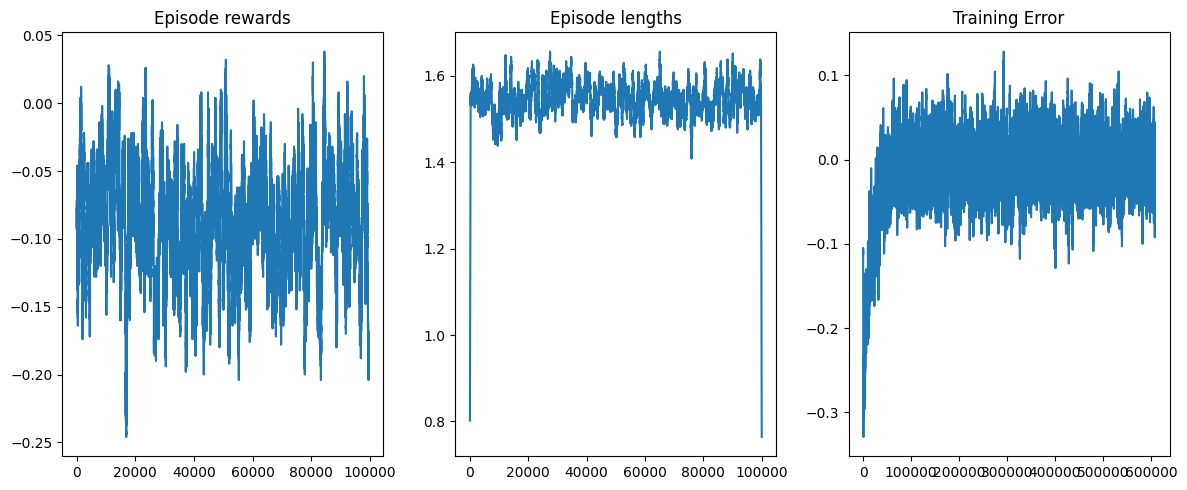

In [42]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(expert_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [40]:
# env = gym.make("Blackjack-v1", sab=True)
NUM_TRAJS = 100_000
visualize = False # set to false in order to disable rendering code
if visualize:
    plt.axis('off')
reseed(1)
total_expert_reward = 0
i = 0
for _ in tqdm(range(NUM_TRAJS)):
  terminated = False
  obs, info = env.reset()
  while not terminated:
    i += 1
    if visualize and i%20==0:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert_agent.get_action(env, obs)
    obs, reward, terminated, truncated, info = env.step(action)
    total_expert_reward += reward
    if terminated:
        break
total_expert_reward /= NUM_TRAJS
print(f"\nTotal Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

100%|██████████| 100000/100000 [00:26<00:00, 3768.20it/s]


Total Reward using Expert Policy = -0.0884
Total Reward using Random Actions = -0.3981



BC Learner Agent, just a 2 layer neural network

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class Learner(nn.Module):
    def __init__(self, env, input_dim, output_dim, hidden_dim = 128, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(input_dim), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.env = env
        self.random_prob = random_prob

        self.training_loss = []

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc_out(x)
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor(obs).float().to(device))

        # action = self.forward(torch.tensor([obs]).float().to(device))
        return np.argmax(np.array(action[0].detach().cpu()))

    def train(self, observations, actions, validation_obs, validation_acts, checkpoint_path=None, num_epochs=100):
        """Train function for learning a new policy using BC.

        Parameters:
            learner (Learner)
                A Learner object (policy)
            observations (list of numpy.ndarray)
                A list of numpy arrays of shape (7166, 11, )
            actions (list of numpy.ndarray)
                A list of numpy arrays of shape (7166, 3, )
            checkpoint_path (str)
                The path to save the best performing checkpoint
            num_epochs (int)
                Number of epochs to run the train function for

        Returns:
            learner (Learner)
                A Learner object (policy)
        """
        best_loss = float("inf")
        best_model_state = None

        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        dataset = TensorDataset(
            observations.to(torch.float32), actions.to(torch.float32)
        )  # Create your dataset
        dataloader = DataLoader(
            dataset, batch_size=32, shuffle=True
        )  # Create your dataloader
        # val dataloader
        # val_dataloader = DataLoader(TensorDataset(validation_obs.to(torch.float32), validation_acts.to(torch.float32)),batch_size=256,shuffle=True)

        device = torch.device("cpu")
        self.to(device)

        loss = float("inf")
        validation_losses = []
        for epoch in tqdm(range(num_epochs)):
            epoch_loss = 0

            for inp, out in dataloader:
                # print(f"Input shape: {inp.shape}, Output shape: {out.shape}")
                optimizer.zero_grad()
                preds = self(inp).squeeze()
                # print(f"Predictions shape: {preds.shape}")
                loss = loss_fn(preds, out.squeeze())
                # print(f"Loss: {loss.item()}")

                self.training_loss.append(loss.item())
                loss.backward()
                epoch_loss += loss
                optimizer.step()

            with torch.no_grad():
                val_pred = self(validation_obs.float()).squeeze()
                val_loss = loss_fn(val_pred, validation_acts.float().squeeze())

                validation_losses.append(val_loss)

            # Saving model state if current loss is less than best loss
            if epoch_loss < best_loss:
                best_loss = loss
                best_model_state = self.state_dict()

        return self.training_loss, validation_losses

In [15]:
input_dim = 3 # env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n
output_dim = 1 # env.action_space.n

bc_learner = Learner(env, input_dim, output_dim)
device = torch.device("cpu")
bc_learner.to(device)
training_loss, validation_loss = bc_learner.train(torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path = None, num_epochs = 200)

100%|██████████| 200/200 [24:04<00:00,  7.22s/it]


In [49]:
# env = gym.make("Blackjack-v1", sab=True)
# env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes, stats_key = "learner_eval")

NUM_TRAJS = 100_000
visualize = False # set to false in order to disable rendering code
reseed(2)
total_learner_reward = 0
i= 0


rewards = []

for _ in tqdm(range(NUM_TRAJS)):
  terminated = False
  obs, info = env.reset()
  while not terminated:
    i += 1
    if visualize and i%20==0:
      ipythondisplay.clear_output(wait=True)
      screen = env.render()
      plt.imshow(screen[0])
      ipythondisplay.display(plt.gcf())
    with torch.no_grad():
      action = bc_learner.get_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    total_learner_reward += reward
    if terminated or truncated:
      break
total_learner_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

100%|██████████| 100000/100000 [01:01<00:00, 1632.62it/s]

Total Reward using Expert Policy = -0.0884
Total Reward using Learned Policy = -0.18617



In [50]:
# env= gym.make("Blackjack-v1", sab=True)
# env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

NUM_TRAJS = 100_000
learner_reward = 0

for episode in tqdm(range(NUM_TRAJS)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = bc_learner.get_action(obs)

        obs, reward, terminated, truncated, info = env.step(action)
        learner_reward += reward

        # update if the environment is done and the current obs
        done = terminated or truncated
        if done:
          break

learner_reward /= NUM_TRAJS
print(f"\nTotal Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {learner_reward}\n")


100%|██████████| 100000/100000 [01:07<00:00, 1474.35it/s]


Total Reward using Expert Policy = -0.0884
Total Reward using Learned Policy = -0.1857



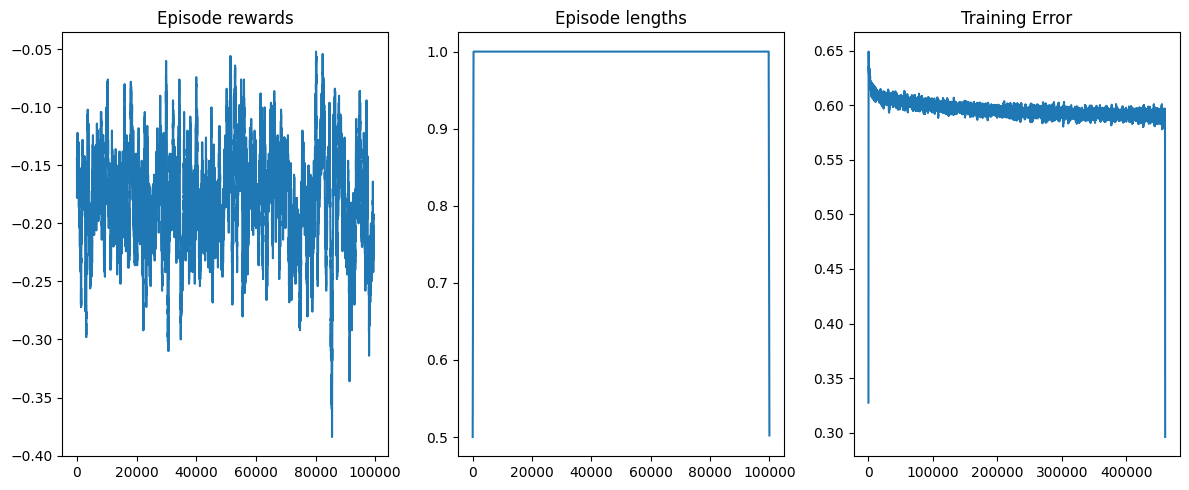

In [39]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(bc_learner.training_loss), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [55]:
def evaluate(env, learner):
    num_trajs = 50
    total_learner_reward = 0
    for _ in tqdm(range(num_trajs)):
        terminated = False
        obs, info = env.reset()
        while not terminated:
            with torch.no_grad():
                action = learner.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_learner_reward += reward
            if terminated or truncated:
              break
    total_learner_reward /= num_trajs
    return total_learner_reward



def interact(env, learner, expert, observations, actions, val_obs, val_acts, checkpoint_path=None, seed=4756, num_epochs=100, horizon=1000):
    """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert (ExpertActor)
            An ExpertActor object (expert policy)
        observations (torch.tensor of numpy.ndarray)
            An initially empty list of numpy arrays
        actions (torch.tensor of numpy.ndarray)
            An initially empty list of numpy arrays
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
    NUM_INTERACTIONS = 5
    best_reward = 0
    rewards = []
    best_model_state = None
    device = torch.device("cpu")

    for eps in range(NUM_INTERACTIONS):
        for _ in range(10):
            obs, info = env.reset()
            done = False
            for t in range(horizon):
                learner_action = learner.get_action(obs)
                observations = torch.cat((observations, torch.unsqueeze(torch.tensor(obs), 0).to(observations.device)), dim=0)
                next_obs, reward, terminated, truncated, info = env.step(learner_action)
                expert_action = expert.get_action(env, obs)
                actions = torch.cat((actions, torch.unsqueeze(torch.tensor(expert_action), 0).to(actions.device)), dim=0)
                obs = next_obs
                if terminated or truncated:
                    break
        training_loss, validation_loss = learner.train(observations, actions, val_obs, val_acts, checkpoint_path = None, num_epochs = num_epochs)
        r = evaluate(env, learner)
        rewards.append(r)
        if r > best_reward:
            best_reward = r
            best_model_state = learner.state_dict()
    return rewards, best_model_state

In [56]:
dagger_learner = bc_learner
device = "cpu"
dagger_learner.to(device)
reseed(2)



interact(env, dagger_learner, expert_agent, torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path = None, seed = seed, num_epochs = 200)

100%|██████████| 50/50 [00:00<00:00, 2028.63it/s]


([-0.04, 0.02, -0.12, -0.36, -0.08],
 OrderedDict([('fc1.weight',
               tensor([[ 0.1865, -0.6850, -0.7740],
                       [-0.3538, -0.1764, -0.3333],
                       [-0.2940,  0.8798, -0.1824],
                       [-0.1178, -0.4893, -0.5650],
                       [ 0.2533, -0.6927, -0.8955],
                       [-0.0699, -0.1380, -0.5420],
                       [-0.5527, -0.1302,  0.4228],
                       [-0.0478, -0.0798,  0.8401],
                       [-0.4133, -0.0899,  0.5648],
                       [-0.5446,  0.2237,  0.1384],
                       [-0.5605,  0.5219, -0.3619],
                       [-0.0408, -0.4692,  0.5582],
                       [ 0.0786, -0.1013, -0.3817],
                       [-0.0753,  0.4553, -1.2873],
                       [-0.4019, -0.4349,  0.3506],
                       [ 0.1232, -0.0683, -0.3797],
                       [ 0.1621, -0.1136, -0.6939],
                       [-0.3632,  0.0327,  0.3671]

In [57]:
NUM_TRAJS = 100_000
dagger_reward = 0

for episode in tqdm(range(NUM_TRAJS)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = dagger_learner.get_action(obs)

        obs, reward, terminated, truncated, info = env.step(action)
        dagger_reward += reward

        # update if the environment is done and the current obs
        done = terminated or truncated
        if done:
          break

dagger_reward /= NUM_TRAJS
print(f"\nTotal Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {dagger_reward}\n")

100%|██████████| 100000/100000 [01:01<00:00, 1639.34it/s]


Total Reward using Expert Policy = -0.0884
Total Reward using Learned Policy = -0.1827



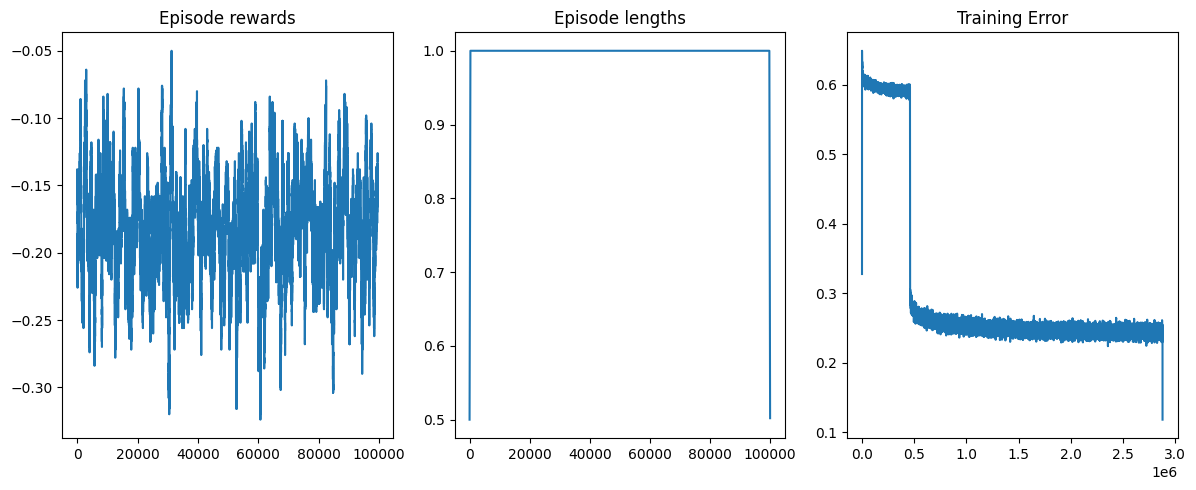

In [58]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(dagger_learner.training_loss), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()